# Monte carlo policy gradient in Cartpole Env
## Important Points
### Optimizes policy based on monte carlo methods
### It collects trajectory samples from one episode using its current policy and uses them to the policy parameters,θ 

In [14]:
# Reinforce algorithm to solve the cartploe environment
import gym
import torch
import torch.nn as nn

env = gym.make('CartPole-v0')

# PolicyNetworkClass which approximates the policy using Neural Network

In [15]:
class PolicyNetwork():
    def __init__(self, n_state, n_action, n_hidden=50, lr=0.001):
        # The input of the policy network is a state, followed by a hidden layer, 
        # while the output is the probability of taking possible individual actions.
        # Therefore, we use the softmax function as the activation for the output layer.
        self.model = nn.Sequential(
                        nn.Linear(n_state, n_hidden),
                        nn.ReLU(),
                        nn.Linear(n_hidden, n_action),
                        nn.Softmax(),
                )
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr)


    def predict(self, s):
        """
        Compute the action probabilities of state s using the learning model
        @param s: input state
        @return: predicted policy
        """
        return self.model(torch.Tensor(s))


    def update(self, returns, log_probs):
        """
        Update the weights of the policy network given the training samples
        @param returns: return (cumulative rewards) for each step in an episode
        @param log_probs: log probability for each step
        """

        """given all the data gathered in an episode,
           including the returns and the log probabilities of all steps, we compute the policy gradients,
           and then update the policy parameters accordingly via backpropagation.
        """
        policy_gradient = []
        for log_prob, Gt in zip(log_probs, returns):
            policy_gradient.append(-log_prob * Gt)

        loss = torch.stack(policy_gradient).sum()
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()


    def get_action(self, s):
        """
        Estimate the policy and sample an action, compute its log probability
        @param s: input state
        @return: the selected action and log probability
        """
        probs = self.predict(s)
        action = torch.multinomial(probs, 1).item()
        log_prob = torch.log(probs[action])
        return action, log_prob



# Reinforce algorithm with a policy network model


1.   It runs an episode: for each step in the episode, it samples an action based on the
current estimated policy; it stores the reward and the log policy at each step.
2.   Once an episode finishes, it calculates the discounted cumulative rewards at each
step; it normalizes the resulting returns by subtracting their mean and then
dividing them by their standard deviation.

3.   Once an episode finishes, it calculates the discounted cumulative rewards at each
step; it normalizes the resulting returns by subtracting their mean and then
dividing them by their standard deviation.

4.   It runs n_episode episodes by repeating the aforementioned steps.



In [16]:
def reinforce(env, estimator, n_episode, gamma=1.0):
  """
  Reinforce algo
  @param env : Gym Envirnoment
  @param estimator: policy network
  @param n_episode: number of episodes
  @param gamma : the discount factor
  """

  for episode in range(n_episode):
    log_probs = []
    rewards = []
    state = env.reset()

    while True:
      action, log_prob = estimator.get_action(state)
      next_state, reward, is_done, _ = env.step(action)
      total_reward_episode[episode] += reward

      log_probs.append(log_prob)
      rewards.append(reward)

      if is_done:

        returns = []

        Gt = 0
        pw = 0

        for rewards in rewards[::-1]:
          Gt += gamma ** pw * reward
          pw += 1
          returns.append(Gt)

        returns = returns[::-1]
        returns = torch.tensor(returns)
        returns = (returns - returns.mean()) / (returns.std() +1e-9)
        
        estimator.update(returns, log_probs)
        print('Episode: {}, total reward: {}'.format(episode, total_reward_episode[episode]))
        break
      
      state = next_state


# Input Parameters

In [17]:
n_state = env.observation_space.shape[0]
n_action = env.action_space.n
n_hidden = 128
lr = 0.003

policy_net = PolicyNetwork(n_state, n_action, n_hidden, lr)

gamma = 0.9 # discount factor

n_episode = 500 # For 500 episodes
total_reward_episode = [0] * n_episode # Track of the total rewards for each episode

reinforce(env, policy_net, n_episode, gamma)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Episode: 0, total reward: 25.0
Episode: 1, total reward: 25.0
Episode: 2, total reward: 13.0
Episode: 3, total reward: 11.0
Episode: 4, total reward: 26.0
Episode: 5, total reward: 27.0
Episode: 6, total reward: 28.0
Episode: 7, total reward: 14.0
Episode: 8, total reward: 25.0
Episode: 9, total reward: 17.0
Episode: 10, total reward: 23.0
Episode: 11, total reward: 47.0
Episode: 12, total reward: 31.0
Episode: 13, total reward: 24.0
Episode: 14, total reward: 29.0
Episode: 15, total reward: 59.0
Episode: 16, total reward: 46.0
Episode: 17, total reward: 20.0
Episode: 18, total reward: 85.0
Episode: 19, total reward: 29.0
Episode: 20, total reward: 19.0
Episode: 21, total reward: 12.0
Episode: 22, total reward: 32.0
Episode: 23, total reward: 21.0
Episode: 24, total reward: 28.0
Episode: 25, total reward: 68.0
Episode: 26, total reward: 39.0
Episode: 27, total reward: 24.0
Episode: 28, total reward: 53.0
Episode: 29, total reward: 31.0
Episode: 30, total reward: 34.0
Episode: 31, total

# Visualisation of Episode reward over time

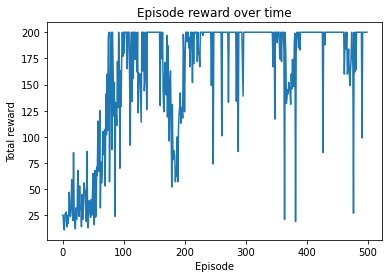

In [18]:
import matplotlib.pyplot as plt
plt.plot(total_reward_episode)
plt.title('Episode reward over time')
plt.xlabel('Episode')
plt.ylabel('Total reward')
plt.show()